<a href="https://colab.research.google.com/github/haoheliu/demopage-voicefixer/blob/main/VoiceFixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VoiceFixer

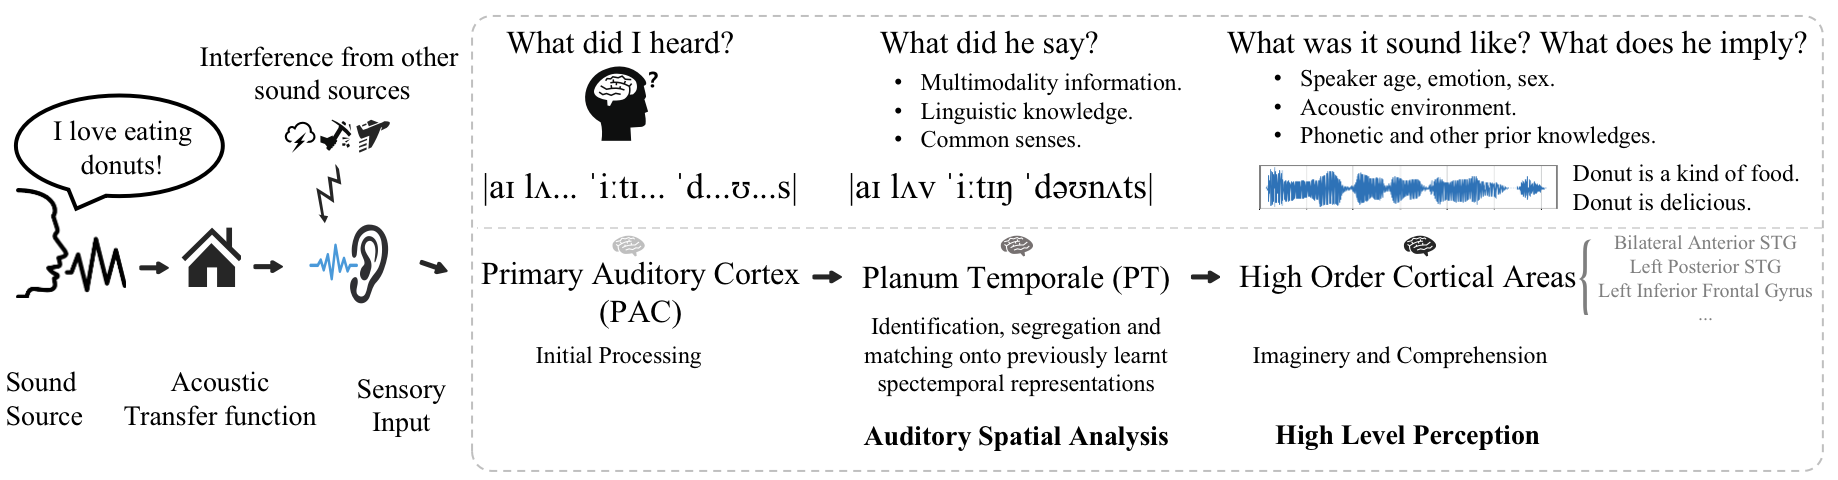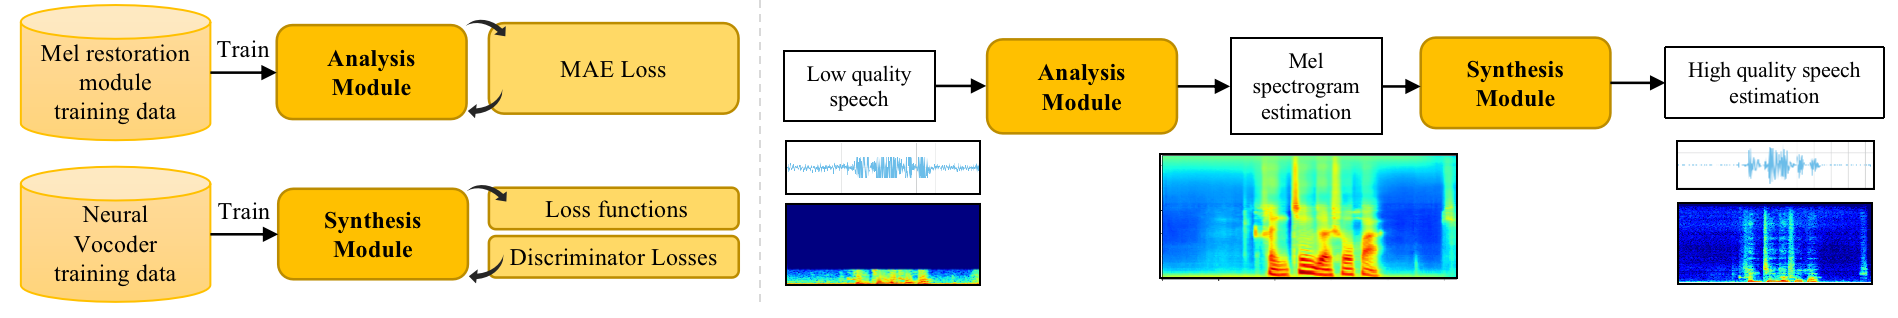

In [1]:
#@title Run this block to prepare the environment, it may take 3-5 minutes
! apt-get install libsox-fmt-all libsox-dev sox > /dev/null
! python -m pip install torchaudio > /dev/null
! pip install ffmpeg-python > /dev/null
! pip install torchaudio &> /dev/null
! sudo apt-get install libsndfile-dev &> /dev/null
! pip install --upgrade pip &> /dev/null
! pip install --upgrade ddsp &> /dev/null
! pip install voicefixer==0.0.4 &> /dev/null
! apt-get install libsox-fmt-all libsox-dev sox > /dev/null
! python -m pip install torchaudio > /dev/null
! python -m pip install git+https://github.com/facebookresearch/WavAugment.git > /dev/null
! pip install ffmpeg-python > /dev/null

import IPython.display as ipd; from IPython.display import HTML, Audio
from google.colab.output import eval_js
import base64; from base64 import b64decode
import numpy as np; import io; import ffmpeg; import tempfile; import pathlib; import torchaudio
import torch; import soundfile as sf
import io; import pickle; import ddsp; import ddsp.training; from google.colab import files; from google.colab import output
from IPython import display; import note_seq; from scipy.io import wavfile
import tensorflow.compat.v2 as tf
import augment; import librosa; from matplotlib import cm; import matplotlib.pyplot as plt

# Import VoiceFixer! 
from voicefixer import VoiceFixer, Vocoder

download = files.download

DEFAULT_SAMPLE_RATE = ddsp.spectral_ops.CREPE_SAMPLE_RATE

_play_count = 0  # Used for ephemeral play().

# Alias these for backwards compatibility and ease.
specplot = ddsp.training.plotting.specplot
plot_impulse_responses = ddsp.training.plotting.plot_impulse_responses
transfer_function = ddsp.training.plotting.transfer_function

def audio_bytes_to_np(wav_data,
                      sample_rate=DEFAULT_SAMPLE_RATE,
                      normalize_db=0.1,
                      mono=True):
  return note_seq.audio_io.wav_data_to_samples_pydub(
      wav_data=wav_data, sample_rate=sample_rate, normalize_db=normalize_db,
      num_channels=1 if mono else None)


def record(seconds=3, sample_rate=DEFAULT_SAMPLE_RATE, normalize_db=0.1):
  # Use Javascript to record audio.
  record_js_code = """
  const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
  const b2text = blob => new Promise(resolve => {
    const reader = new FileReader()
    reader.onloadend = e => resolve(e.srcElement.result)
    reader.readAsDataURL(blob)
  })
  var record = time => new Promise(async resolve => {
    stream = await navigator.mediaDevices.getUserMedia({ audio: true })
    recorder = new MediaRecorder(stream)
    chunks = []
    recorder.ondataavailable = e => chunks.push(e.data)
    recorder.start()
    await sleep(time)
    recorder.onstop = async ()=>{
      blob = new Blob(chunks)
      text = await b2text(blob)
      resolve(text)
    }
    recorder.stop()
  })
  """
  print('Starting recording for {} seconds...'.format(seconds))
  display.display(display.Javascript(record_js_code))
  audio_string = output.eval_js('record(%d)' % (seconds * 1000.0))
  print('Finished recording!')
  audio_bytes = base64.b64decode(audio_string.split(',')[1])
  return audio_bytes_to_np(audio_bytes,
                           sample_rate=sample_rate,
                           normalize_db=normalize_db)

  Running command git clone -q https://github.com/facebookresearch/WavAugment.git /tmp/pip-req-build-z44m4ath


In [2]:
#@title Run this block to define some helper functions
def uniform_sample(lower, upper):
    if(abs(lower-upper)<1e-5):
        return upper
    return float((upper-lower)*torch.rand(1)+lower)

def show_spectrogram(file_path):
    samples,_ = librosa.load(file_path,sr=44100)
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.title("Linear Spectrogram")
    librosa.display.specshow(
        np.log10(np.abs(librosa.stft(samples))+1e-8),
        sr=44100,
        x_axis='frames',
        y_axis='linear',
        cmap=cm.jet,
        vmax=2.8,
        vmin=-1.7)
    plt.subplot(122)
    plt.title("Mel Spectrogram")
    librosa.display.specshow(
        np.log10(np.abs(librosa.feature.melspectrogram(samples,sr=44100))+1e-8),
        sr=44100,
        x_axis='frames',
        y_axis='mel',
        cmap=cm.jet,
        vmax=2.5,
        vmin=-4)
    plt.show()

Let's play with VoiceFixer! It will fix your voice to 44.1kHz high quality speech.

In [3]:
second=6 # Record your voice for 6s
rate = 16000 # Record at a samplerate of 16000
vf = VoiceFixer() # Initilize a voicefixer.

**Record your voice for 3 seconds using the following code.**

You could say "I love donuts" or anything you like! Singing is not well supported currently.

In [50]:
a = record(seconds=second, sample_rate=rate)
# sf.write(str(second)+"_"+str(rate)+".wav",a,rate)
# show_spectrogram(str(second)+"_"+str(rate)+".wav")
# ipd.Audio(str(second)+"_"+str(rate)+".wav", rate=44100)

Starting recording for 6 seconds...


<IPython.core.display.Javascript object>

Finished recording!


**Mannuly add distortions.**

In [55]:
# Generate Random Parameters
clipping_ratio = uniform_sample(lower=0.15,upper=0.5); print("clipping ratio: ", clipping_ratio) # lower>=0.1, upper<=1.0
lowpass_frequency = uniform_sample(lower=3000,upper=8000); print("lowpass cutoff frequency: ", lowpass_frequency) # lower>=1000, and upper have no limit
reverb_level = uniform_sample(lower=30,upper=60) # lower>=0, upper<=100
dumping_factor = uniform_sample(lower=10,upper=30) # lower>=0, upper<=100
room_size = uniform_sample(lower=5,upper=10); print("reverberate level, dumping_factor, room_size = ",reverb_level,dumping_factor,room_size) # lower>=0, upper<=100
highpass = uniform_sample(lower=500,upper=1500); print("highpass cutoff frequency: ", highpass) # lower>=0, upper<=2000

# Apply effects
effect_chain = augment.EffectChain().clip(clipping_ratio) # clipping ratio
effect_chain = effect_chain.lowpass(lowpass_frequency) # remove high frequency information
effect_chain = effect_chain.reverb(reverb_level, dumping_factor, room_size).channels(1) # reverberate level, dumping factor, room size
effect_chain = effect_chain.highpass(highpass) # remove low frequency information
y = effect_chain.apply(torch.tensor(a), src_info={'rate': rate})

clipping ratio:  0.16760893166065216
lowpass cutoff frequency:  6400.392578125
reverberate level, dumping_factor, room_size =  31.653650283813477 20.35511016845703 8.599916458129883
highpass cutoff frequency:  851.7806396484375


**We mannuly add some more distortions on it. We will restore the following speech later.**

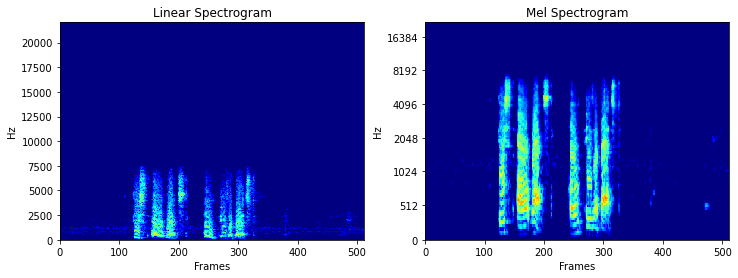

In [56]:
sf.write(str(second)+"_"+str(rate)+".wav",y[0,...].numpy(),rate)
show_spectrogram(str(second)+"_"+str(rate)+".wav")
ipd.Audio(str(second)+"_"+str(rate)+".wav", rate=44100)

**Restore this record.**

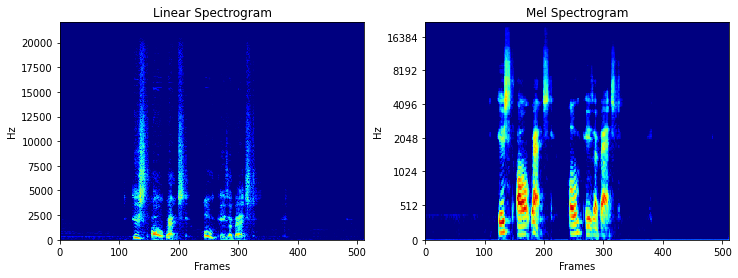

In [57]:
vf.restore(input=str(second)+"_"+str(rate)+".wav",output="out"+str(second)+"_"+str(rate)+".wav",cuda=True)
show_spectrogram("out"+str(second)+"_"+str(rate)+".wav")
ipd.Audio("out"+str(second)+"_"+str(rate)+".wav", rate=44100)

Vocoder can be used in this way.

In [58]:
vocoder = Vocoder(44100).cuda()
vocoder.oracle("out"+str(second)+"_"+str(rate)+".wav","out"+str(second)+"_"+str(rate)+"_vocoder_oracle.wav")
ipd.Audio("out"+str(second)+"_"+str(rate)+"_vocoder_oracle.wav", rate=44100)